In [ ]:
import pandas as pd
from scipy.stats import linregress
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.stats import lognorm
from scipy.stats import norm
import numpy as np


In [ ]:
from google.colab import drive
drive.mount('/content/drive') # Mount your Google Drive to access the datasets, make sure to authorize in the pop-up window

Mounted at /content/drive


In [ ]:
df_filtered = pd.read_csv("/content/drive/My Drive/DSF Datasets/DSF_filtered_data.csv")

In [ ]:
df_test = pd.read_csv("/content/drive/My Drive/DSF Datasets/final_train_data.csv")
df_train = pd.read_csv("/content/drive/My Drive/DSF Datasets/final_test_data.csv")

In [ ]:

print(len(df_train))
print(len(df_test))
print(len(df_filtered))


16436
2191
18627


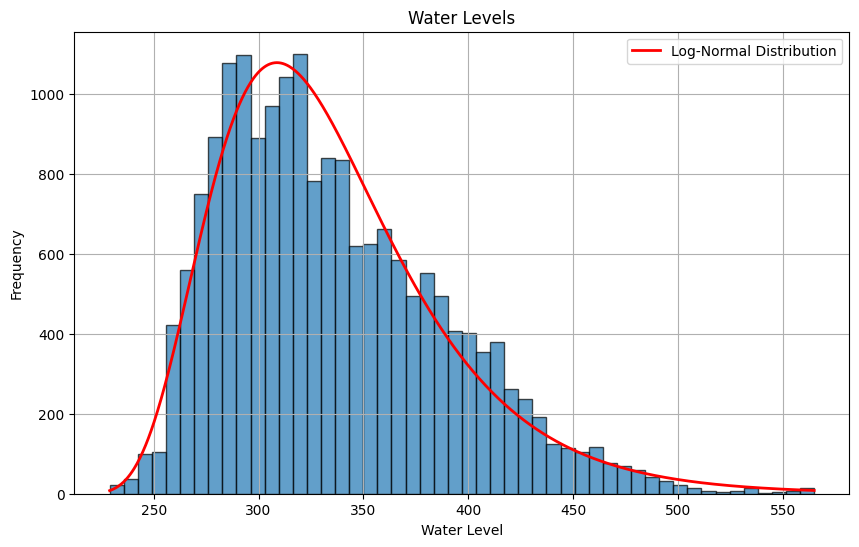

In [ ]:
#see how Water levels are distributed to see if transformation is needed:
# make log-normal distribution for plotting
shape, loc, scale = lognorm.fit(df_filtered["WATER_LEVEL"])
# Generate values for the fitted Log-Normal curve
x = np.linspace(df_filtered["WATER_LEVEL"].min(), df_filtered["WATER_LEVEL"].max(), 1000)
bin_width = (df_filtered["WATER_LEVEL"].max() - df_filtered["WATER_LEVEL"].min()) / 50
fitted_pdf = lognorm.pdf(x, shape, loc, scale) * len(df_filtered["WATER_LEVEL"]) * bin_width


plt.figure(figsize=(10, 6))


# red line on plot as the log-normal curve
plt.plot(x, fitted_pdf, color='red', lw=2, label="Log-Normal Distribution")


plt.hist(df_filtered["WATER_LEVEL"], bins=50, edgecolor='k', alpha=0.7)
plt.title("Water Levels")
plt.xlabel("Water Level")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

#we can see: The log-normal distribution captures the overall shape of the histogram reasonably well:
# It reflects the right skewness of the data and the peak of the log-normal curve aligns closely with the mode of the histogram (around 300)
#As many machine learning models (like linear regression, neural networks) perform better when the target variable is closer to a normal distribution
# (as it helps stabilize variance and linearize relationships), we're going to take the log of the target variable

#Right-skewed data can distort detrending and deseasonalization because trends and seasonality might appear exaggerated in skewed data.
#The log transformation compresses large values, making trends and seasonality easier to detect and remove.


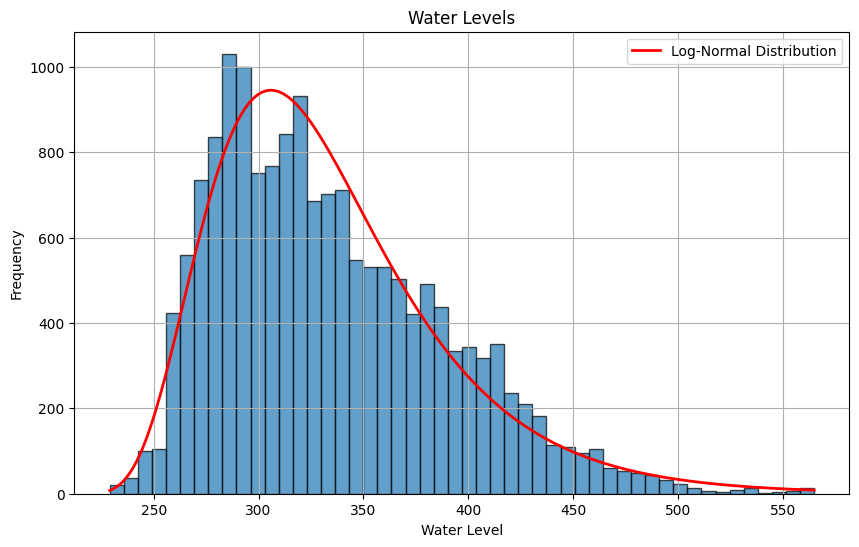

In [ ]:
#just to make sure that test and train data is also log-normal distributed

shape, loc, scale = lognorm.fit(df_train["WATER_LEVEL"])
# Generate values for the fitted Log-Normal curve
x = np.linspace(df_train["WATER_LEVEL"].min(), df_train["WATER_LEVEL"].max(), 1000)
bin_width = (df_train["WATER_LEVEL"].max() - df_train["WATER_LEVEL"].min()) / 50
fitted_pdf = lognorm.pdf(x, shape, loc, scale) * len(df_train["WATER_LEVEL"]) * bin_width


plt.figure(figsize=(10, 6))


# red line on plot as the log-normal curve
plt.plot(x, fitted_pdf, color='red', lw=2, label="Log-Normal Distribution")


plt.hist(df_train["WATER_LEVEL"], bins=50, edgecolor='k', alpha=0.7)
plt.title("Water Levels")
plt.xlabel("Water Level")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()
#train data also follows clear log-normal distribution

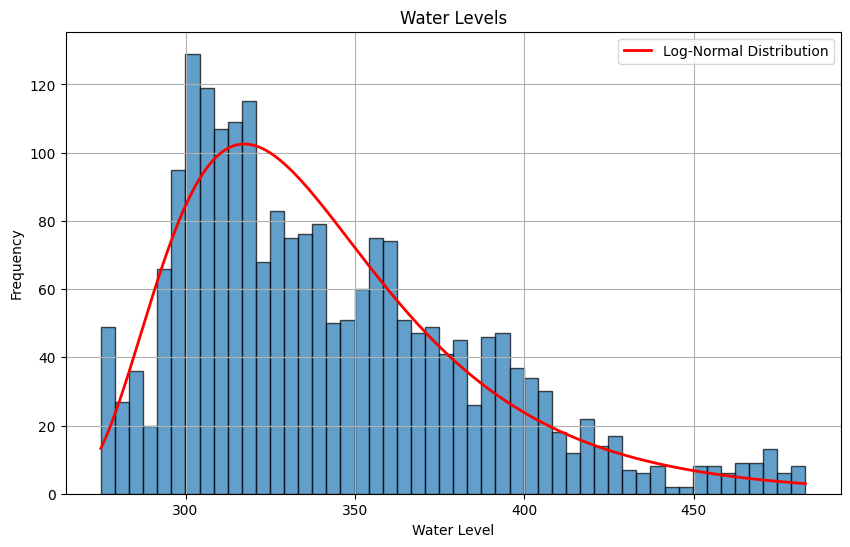

In [ ]:
#distribution of test data
shape, loc, scale = lognorm.fit(df_test["WATER_LEVEL"])

x = np.linspace(df_test["WATER_LEVEL"].min(), df_test["WATER_LEVEL"].max(), 1000)
bin_width = (df_test["WATER_LEVEL"].max() - df_test["WATER_LEVEL"].min()) / 50
fitted_pdf = lognorm.pdf(x, shape, loc, scale) * len(df_test["WATER_LEVEL"]) * bin_width


plt.figure(figsize=(10, 6))

plt.plot(x, fitted_pdf, color='red', lw=2, label="Log-Normal Distribution")


plt.hist(df_test["WATER_LEVEL"], bins=50, edgecolor='k', alpha=0.7)
plt.title("Water Levels")
plt.xlabel("Water Level")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()
#is kind of log-normal distributed-> perform log transformation

Log-transformed Train Data:
count    16436.000000
mean         5.800491
std          0.157098
min          5.433722
25%          5.673323
50%          5.780744
75%          5.913503
max          6.336826
Name: LOG_WATER_LEVEL, dtype: float64
count    16436.000000
mean         5.803538
std          0.156640
min          5.438079
25%          5.676754
50%          5.783825
75%          5.916202
max          6.338594
Name: WATER_LEVEL_LAG_1, dtype: float64
Log-transformed Test Data:
count    2191.000000
mean        5.829090
std         0.122127
min         5.616771
25%         5.733341
50%         5.808142
75%         5.910797
max         6.180017
Name: LOG_WATER_LEVEL, dtype: float64
count    2191.000000
mean        5.831996
std         0.121761
min         5.620401
25%         5.736572
50%         5.811141
75%         5.913503
max         6.182085
Name: WATER_LEVEL_LAG_1, dtype: float64


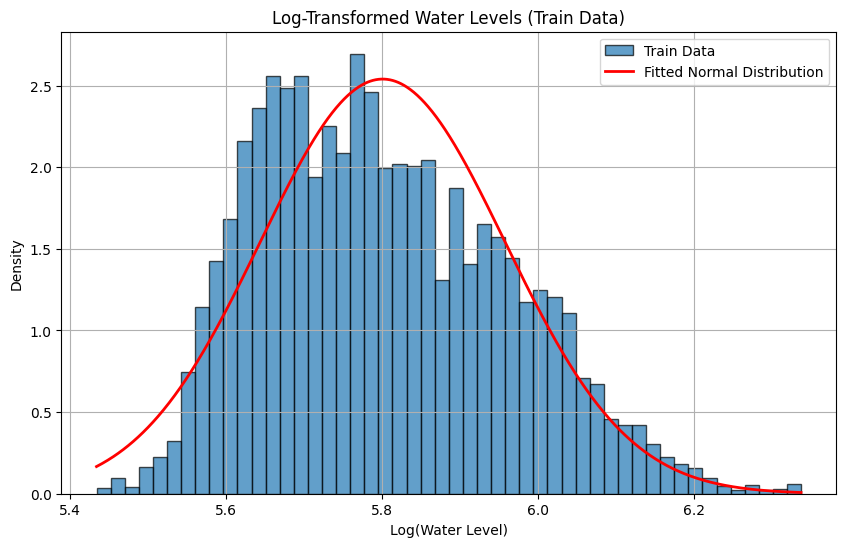

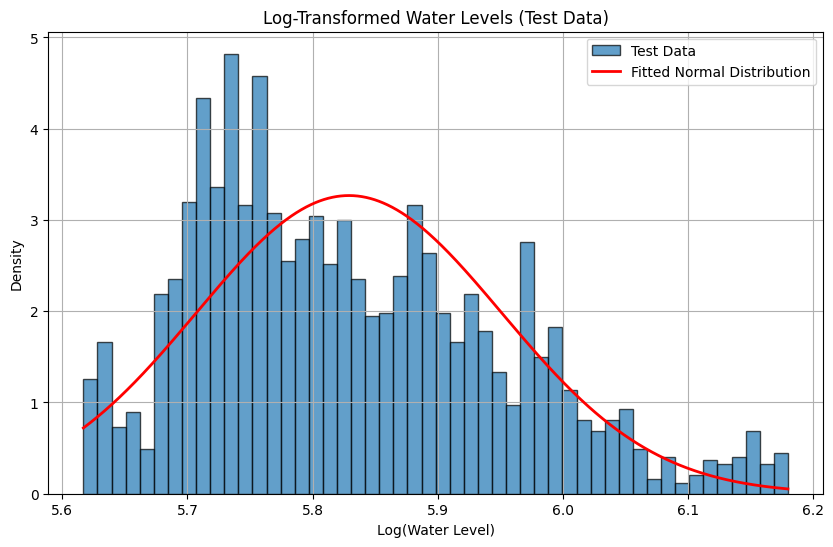

In [ ]:
# Apply the log transformation separately to the target variable in both the training and test sets.
# Log-transform the water levels separately for train and test data
#Comment: is okay to apply the log transformation separately to the training and test data is correct, and it does avoid data leakage, as the log transformation
#is deterministic and does not depend on the dataset's distribution. However, made it more complicated...

#Also log transform the lagged features because follow same distribution!!!! -> The relationship between the lagged features and the target remains linear (or at least comparable).


df_train['LOG_WATER_LEVEL'] = np.log(df_train['WATER_LEVEL'])
df_test['LOG_WATER_LEVEL'] = np.log(df_test['WATER_LEVEL'])

#for lagged columns (do it directly in place):
columns_to_transform = [
    "WATER_LEVEL_LAG_1", "WATER_LEVEL_LAG_2", "WATER_LEVEL_LAG_3",
    "WATER_LEVEL_LAG_4", "WATER_LEVEL_LAG_5", "WATER_LEVEL_LAG_6",
    "WATER_LEVEL_LAG_7"
]

for col in columns_to_transform:
    df_train[col] = np.log(df_train[col] + 1)
    df_test[col] = np.log(df_test[col] + 1)

# Describe the transformed data
print("Log-transformed Train Data:")
print(df_train['LOG_WATER_LEVEL'].describe())
print(df_train['WATER_LEVEL_LAG_1'].describe())

print("Log-transformed Test Data:")
print(df_test['LOG_WATER_LEVEL'].describe())
print(df_test['WATER_LEVEL_LAG_1'].describe())

# Plot the histograms and fitted normal distribution curves
# Train Data
plt.figure(figsize=(10, 6))
plt.hist(df_train['LOG_WATER_LEVEL'], bins=50, alpha=0.7, edgecolor='k', label='Train Data', density=True)

# Fit normal distribution to train data
mu_train, std_train = norm.fit(df_train['LOG_WATER_LEVEL'])
x_train = np.linspace(df_train['LOG_WATER_LEVEL'].min(), df_train['LOG_WATER_LEVEL'].max(), 1000)
pdf_train = norm.pdf(x_train, mu_train, std_train)
plt.plot(x_train, pdf_train, color='red', lw=2, label='Fitted Normal Distribution')

plt.title("Log-Transformed Water Levels (Train Data)")
plt.xlabel("Log(Water Level)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

# Test Data
plt.figure(figsize=(10, 6))
plt.hist(df_test['LOG_WATER_LEVEL'], bins=50, alpha=0.7, edgecolor='k', label='Test Data', density=True)

# Fit normal distribution to test data
mu_test, std_test = norm.fit(df_test['LOG_WATER_LEVEL'])
x_test = np.linspace(df_test['LOG_WATER_LEVEL'].min(), df_test['LOG_WATER_LEVEL'].max(), 1000)
pdf_test = norm.pdf(x_test, mu_test, std_test)
plt.plot(x_test, pdf_test, color='red', lw=2, label='Fitted Normal Distribution')

plt.title("Log-Transformed Water Levels (Test Data)")
plt.xlabel("Log(Water Level)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

Log-transformed values in df_filtered (Train Data):
0    5.638355
1    5.634790
2    5.631212
3    5.627621
4    5.620401
Name: LOG_WATER_LEVEL, dtype: float64


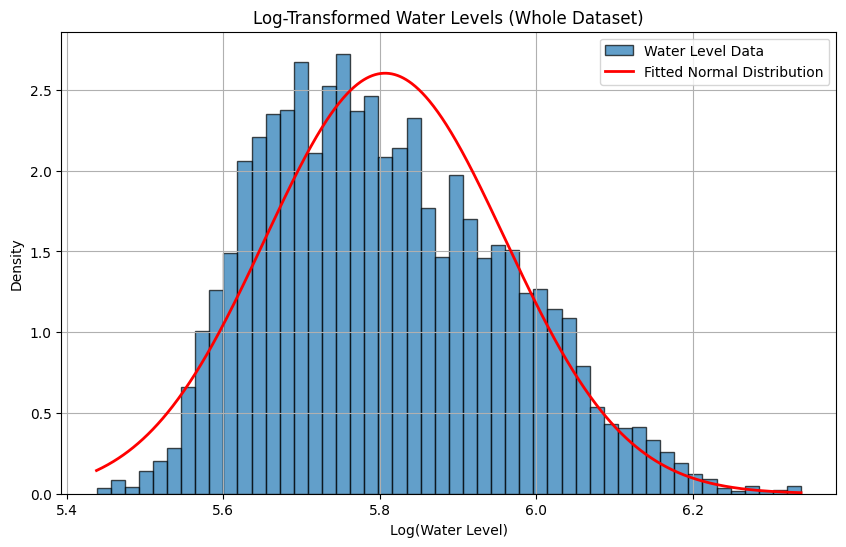

In [ ]:
#also insert the values in df_filtered without mixing stuff:


# Create a column for the log-transformed values (don't need to be the ones from train bzw test because is just a log transformation)

df_filtered['LOG_WATER_LEVEL'] = np.log(df_filtered['WATER_LEVEL'] + 1)

# Log-transform lagged columns
columns_to_transform = [
    "WATER_LEVEL_LAG_1", "WATER_LEVEL_LAG_2", "WATER_LEVEL_LAG_3",
    "WATER_LEVEL_LAG_4", "WATER_LEVEL_LAG_5", "WATER_LEVEL_LAG_6",
    "WATER_LEVEL_LAG_7"
]

for col in columns_to_transform:
    df_filtered[col] = np.log(df_filtered[col] + 1)

# Verify the transformation
print("Log-transformed values in df_filtered (Train Data):")
print(df_filtered['LOG_WATER_LEVEL'].head())


plt.figure(figsize=(10, 6))
plt.hist(df_filtered['LOG_WATER_LEVEL'], bins=50, alpha=0.7, edgecolor='k', density=True, label='Water Level Data')

# Fit a normal distribution to the log-transformed data
mu_filtered, std_filtered = norm.fit(df_filtered['LOG_WATER_LEVEL'])
x_filtered = np.linspace(df_filtered['LOG_WATER_LEVEL'].min(), df_filtered['LOG_WATER_LEVEL'].max(), 1000)
pdf_filtered = norm.pdf(x_filtered, mu_filtered, std_filtered)

# Plot the fitted normal distribution
plt.plot(x_filtered, pdf_filtered, color='red', lw=2, label='Fitted Normal Distribution')
plt.title("Log-Transformed Water Levels (Whole Dataset)")
plt.xlabel("Log(Water Level)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

# Reset the index
df_filtered.reset_index(drop=True, inplace=True)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [ ]:
print("Log-transformed lagged values in df_filtered (Train Data):")
print(df_filtered['WATER_LEVEL_LAG_1'].head())


Log-transformed lagged values in df_filtered (Train Data):
0    5.645447
1    5.638355
2    5.634790
3    5.631212
4    5.627621
Name: WATER_LEVEL_LAG_1, dtype: float64


Comment: col Water levels not yet replaced with log values as the analysis of seasonality etc. is easier with the original levels.

In [ ]:
#shortly safe the files
df_filtered.to_csv('/content/drive/My Drive/log_filtered.csv', index=False)
df_train.to_csv('/content/drive/My Drive/log_train.csv', index=False)
df_test.to_csv('/content/drive/My Drive/log_test.csv', index=False)


In [ ]:
#for simplicity:
df=df_filtered

two ways to perceed: for random forest and neural network not detrend and deseason but add cyclical values, because: Deseasoning or detrending removes the seasonal
or long-term trends from the data, which may discard useful information that the model could otherwise learn.
and  by adding cyclical features, random forests can capture periodic patterns as decision trees can split on those engineered features.
However, need to detrend and deseason for ARMA (assumes stationarity) and for linear regressions (need linear relationship between x and y: If the response variable contains trends or seasonal patterns, this can distort the regression model's coefficients, leading to bias.

best to analyze everything on the whole dataset and then split again to not have to do everything 3 times

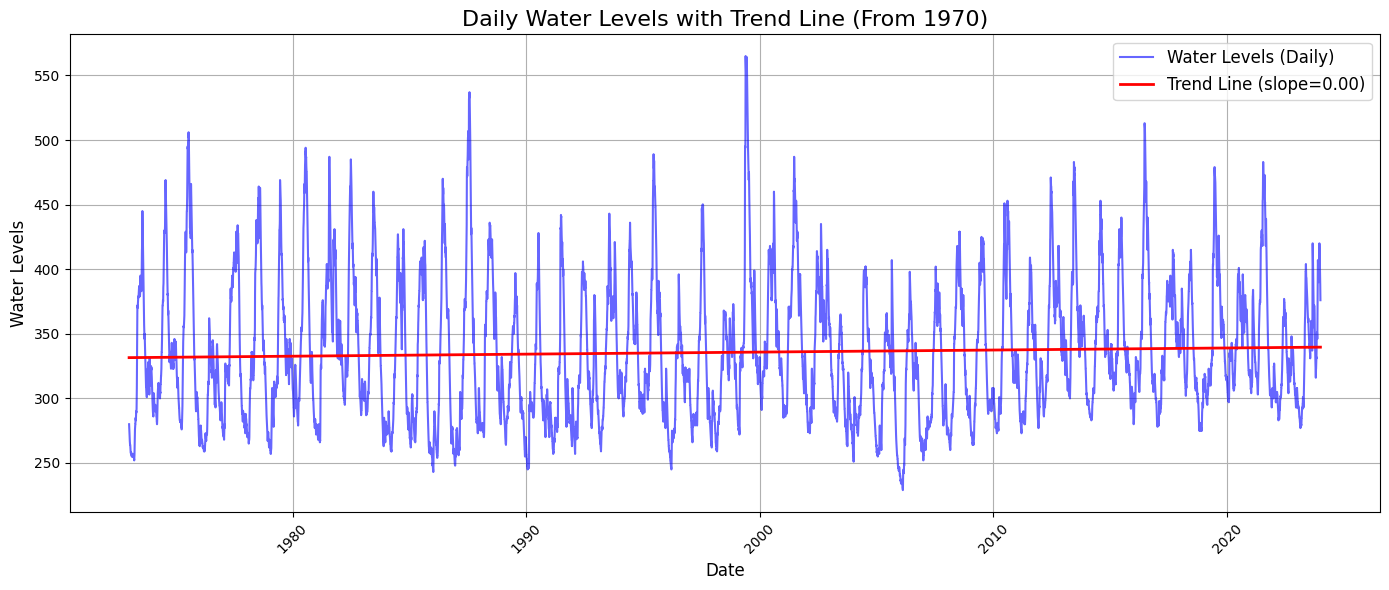

In [ ]:
#general analyzis for trend and seasonality:
#make stationarity check: https://www.geeksforgeeks.org/how-to-check-if-time-series-data-is-stationary-with-python/
#trend:
#extract year tor x-axis:
df['DATE'] = pd.to_datetime(df['DATE'])
df['year'] = df['DATE'].dt.year

# Perform linear regression on daily data for trend line
#Using linear regression to determine the slope is essential because it provides a quantitative measure
# of the relationship between time (e.g., year) and the variable of interest (e.g., water levels).
slope, intercept, r_value, p_value, std_err = linregress(
    df_filtered['DATE'].map(pd.Timestamp.toordinal),  # Convert dates to ordinal format for regression
    df_filtered['WATER_LEVEL']
)

# Compute the trend line
df_filtered['Trend'] = intercept + slope * df_filtered['DATE'].map(pd.Timestamp.toordinal)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df_filtered['DATE'], df_filtered['WATER_LEVEL'], label="Water Levels (Daily)", color='blue', alpha=0.6)
plt.plot(df_filtered['DATE'], df_filtered['Trend'], label=f"Trend Line (slope={slope:.2f})", color='red', linewidth=2)

# Add labels, title, and legend
plt.title("Daily Water Levels with Trend Line (From 1970)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Water Levels", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

#The red line (linear trend) has a slope close to 0, indicating that there is no clear long-term upward or downward trend in
# the water levels over the observed period (from 1970 onwards).
#While the long-term average remains relatively constant, the variability in the peaks and troughs suggests short-term trends
# or local fluctuations.



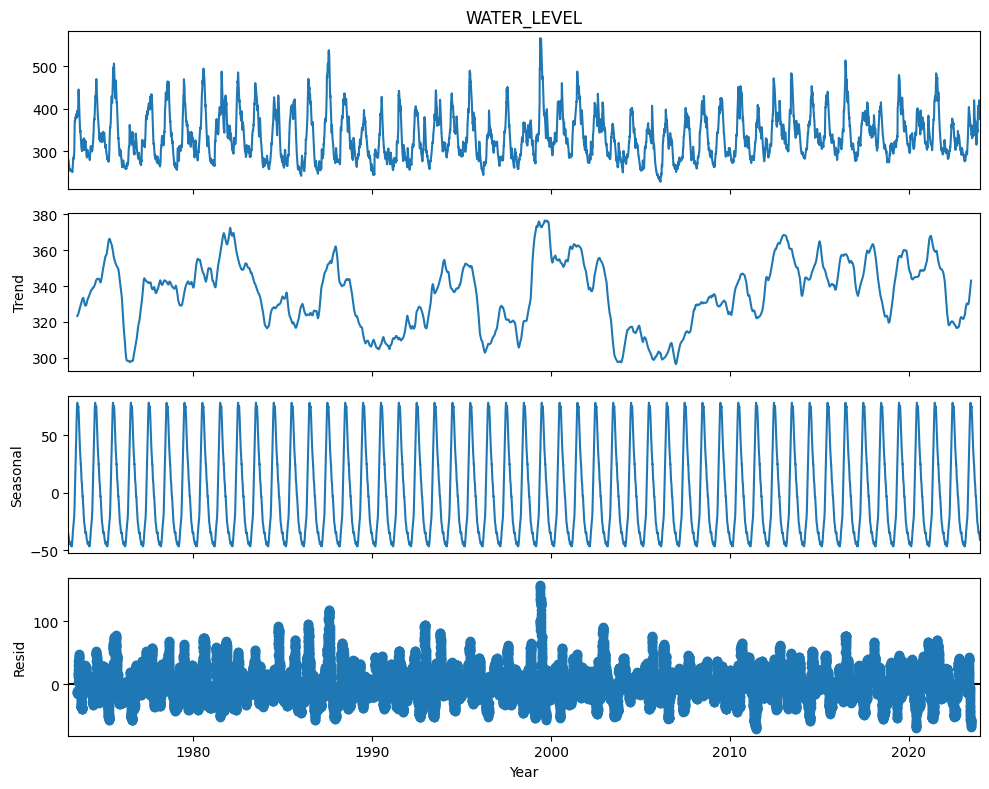

In [ ]:
#to make really sure that there is no trend: can first plot again to look for short term trend and then analyse it statistically with ADF: is done in notebook 04 with the result
#that no trend exists on train and test data after deseasonalizing and data is stationary
#look for trend in a 10 year window.
#saw in other feature engineering file that data is trend-wise stationary(ADF test) but want to check if have trend by decomposing:
import matplotlib.dates as mdates

df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

# Decompose the time series
result = seasonal_decompose(df['WATER_LEVEL'], model='additive', period=365)

# Plot
fig = result.plot()
fig.set_size_inches(10, 8)

for ax in fig.axes[:-1]:
    ax.xaxis.set_major_locator(mdates.YearLocator(10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.set_xlabel("")

fig.axes[-1].xaxis.set_major_locator(mdates.YearLocator(10))
fig.axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.axes[-1].set_xlabel("Year")

plt.tight_layout()
plt.show()

#The trend here suggests that there are longer-term fluctuations, but it's not consistent or linear.
#Instead, it appears to rise and fall over different time periods.
#As the ADF test indicates non-stationarity, need values to capture trend-> going to addtime index to capture trends later on:
# Linear time index is a simple numerical representation of time (e.g., days since the start of the series).

# decomposition shows a trend visually..
df.reset_index(inplace=True)



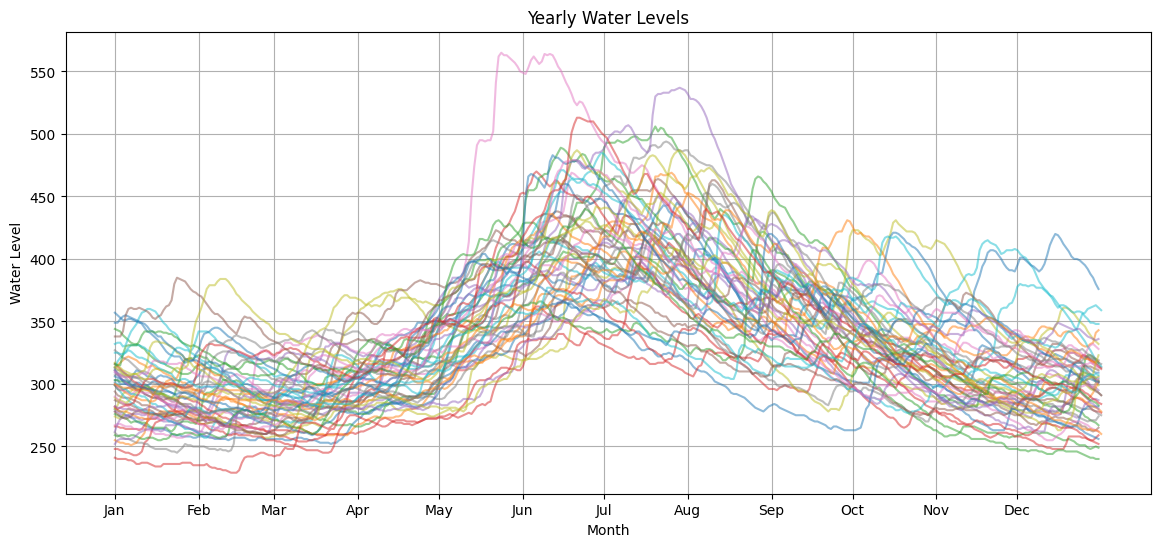

In [ ]:
#Seasonality: first plot water levels then perform Fourier Transform
# (https://nathaniel-lanier.medium.com/fourier-transforms-for-detecting-seasonality-and-feature-engineering-5a91fbfe6e7c)

df['day_of_year'] = df['DATE'].dt.dayofyear

# Plot data for each year
plt.figure(figsize=(14, 6))
for year in df['DATE'].dt.year.unique():
    yearly_data = df[df['DATE'].dt.year == year]
    plt.plot(yearly_data['day_of_year'], yearly_data['WATER_LEVEL'], alpha=0.5, label=year)

# Set x-axis to display months
month_starts = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]  # Approximate starting days of months
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.xticks(month_starts, month_labels)

# Add title, labels, and grid
plt.title("Yearly Water Levels")
plt.xlabel("Month")
plt.ylabel("Water Level")
plt.grid(True)
plt.show()
#-> see clear seasonality in the data



In [ ]:
# Entfernen der Spalte 'day_of_year'
df = df.drop(columns=['day_of_year', 'year', 'Trend'])

# Überprüfen, ob die Spalte entfernt wurde
print(df.head())

        DATE  WATER_LEVEL  HUMIDITY  MEAN_TEMP  PRECIPITATION  PRESSURE  \
0 1973-01-01        280.0      76.0      -22.0            0.0   10291.0   
1 1973-01-02        279.0      83.0      -25.0            0.0   10263.0   
2 1973-01-03        278.0      83.0       -9.0            0.0   10288.0   
3 1973-01-04        277.0      80.0        0.0            0.0   10297.0   
4 1973-01-05        275.0      83.0       -1.0            0.0   10331.0   

   SNOW_DEPTH  SUNSHINE  WIND_SPEED  GLOBAL_RADIATION  ...  MOON_ILLUMINATION  \
0         0.0      75.0         7.0              73.0  ...           18.48788   
1         0.0      23.0        10.0              46.0  ...           11.76654   
2         0.0      21.0         6.0              45.0  ...            6.38749   
3         0.0      11.0        11.0              37.0  ...            2.54398   
4         0.0       8.0        21.0              34.0  ...            0.40753   

   CLIMATE_CHANGE  WATER_LEVEL_LAG_1  WATER_LEVEL_LAG_2  WATER

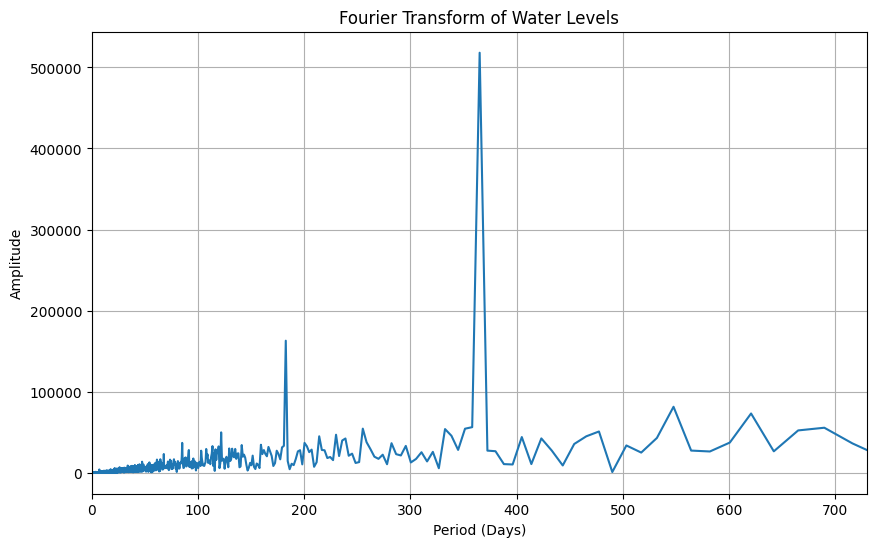

In [ ]:
#Step 2: perform Furrier Transformation
fft_result = np.fft.fft(df['WATER_LEVEL'])
frequencies = np.fft.fftfreq(len(fft_result))
seasonal_period = 365

plt.figure(figsize=(10, 6))
plt.plot(1 / frequencies[1:len(frequencies)//2], np.abs(fft_result)[1:len(frequencies)//2])
plt.xlim(0, 2 * seasonal_period)
plt.title("Fourier Transform of Water Levels")
plt.xlabel("Period (Days)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


#The sharp peak around 365 days suggests that the data has a strong annual seasonality, which corresponds to a periodic cycle of one year
#The smaller peaks (e.g., around 180 days) could represent harmonics of the main annual cycle.

In [ ]:
#now to feature engineering for neural networks and random forest:
#as there is no trend but strong (especially yearly) seasonality: add cyclical data to features:

#see on Furrier Transformation strong yearly seasonality: add yearly cyclical col:
df['day_of_year'] = df['DATE'].dt.dayofyear
df['annual_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['annual_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

#also see strong peak at 180-> Semi-annual seasonality (180-day period)
df['half_annual_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 180)
df['half_annual_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 180)

#expand to quarter annual seasonality to capture seasons of weather change
df['quarter_annual_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 90)
df['quarter_annual_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 90)

#due to weather cycle also expect monthly seasonality, and maybe weekly due to moon cycle but don't want daily because risk of overfitting
df['month'] = df['DATE'].dt.month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Adjust to make Monday=1, Sunday=7
df['day_of_week'] = df['DATE'].dt.dayofweek + 1
df['weekly_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['weekly_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
print(df.head())
#drop unnecessary columns:
df = df.drop(columns=['day_of_year', 'month', 'day_of_week'])
print(df.head())


        DATE  WATER_LEVEL  HUMIDITY  MEAN_TEMP  PRECIPITATION  PRESSURE  \
0 1973-01-01        280.0      76.0      -22.0            0.0   10291.0   
1 1973-01-02        279.0      83.0      -25.0            0.0   10263.0   
2 1973-01-03        278.0      83.0       -9.0            0.0   10288.0   
3 1973-01-04        277.0      80.0        0.0            0.0   10297.0   
4 1973-01-05        275.0      83.0       -1.0            0.0   10331.0   

   SNOW_DEPTH  SUNSHINE  WIND_SPEED  GLOBAL_RADIATION  ...  half_annual_sin  \
0         0.0      75.0         7.0              73.0  ...         0.034899   
1         0.0      23.0        10.0              46.0  ...         0.069756   
2         0.0      21.0         6.0              45.0  ...         0.104528   
3         0.0      11.0        11.0              37.0  ...         0.139173   
4         0.0       8.0        21.0              34.0  ...         0.173648   

   half_annual_cos  quarter_annual_sin  quarter_annual_cos  month  month_s

In [ ]:
#don't need to use time index to capture trends because no trend was visible after deseasonalizing in notebook 04, but time index can help the model
#understand the sequence of events and detect subtle temporal patterns even if no trend -> make it anyway
df['time_index'] = (df['DATE'] - df['DATE'].min()).dt.days
print(df.head())

        DATE  WATER_LEVEL  HUMIDITY  MEAN_TEMP  PRECIPITATION  PRESSURE  \
0 1973-01-01        280.0      76.0      -22.0            0.0   10291.0   
1 1973-01-02        279.0      83.0      -25.0            0.0   10263.0   
2 1973-01-03        278.0      83.0       -9.0            0.0   10288.0   
3 1973-01-04        277.0      80.0        0.0            0.0   10297.0   
4 1973-01-05        275.0      83.0       -1.0            0.0   10331.0   

   SNOW_DEPTH  SUNSHINE  WIND_SPEED  GLOBAL_RADIATION  ...  annual_cos  \
0         0.0      75.0         7.0              73.0  ...    0.999852   
1         0.0      23.0        10.0              46.0  ...    0.999407   
2         0.0      21.0         6.0              45.0  ...    0.998667   
3         0.0      11.0        11.0              37.0  ...    0.997630   
4         0.0       8.0        21.0              34.0  ...    0.996298   

   half_annual_sin  half_annual_cos  quarter_annual_sin  quarter_annual_cos  \
0         0.034899       

In [ ]:
# Move LOG_WATER_LEVEL to the first column and drop water levels
columns = ['LOG_WATER_LEVEL'] + [col for col in df.columns if col not in ['LOG_WATER_LEVEL', 'DATE']]

df = df[['DATE'] + columns]
df = df.drop(columns=['WATER_LEVEL'])
print(df.head())

        DATE  LOG_WATER_LEVEL  HUMIDITY  MEAN_TEMP  PRECIPITATION  PRESSURE  \
0 1973-01-01         5.638355      76.0      -22.0            0.0   10291.0   
1 1973-01-02         5.634790      83.0      -25.0            0.0   10263.0   
2 1973-01-03         5.631212      83.0       -9.0            0.0   10288.0   
3 1973-01-04         5.627621      80.0        0.0            0.0   10297.0   
4 1973-01-05         5.620401      83.0       -1.0            0.0   10331.0   

   SNOW_DEPTH  SUNSHINE  WIND_SPEED  GLOBAL_RADIATION  ...  annual_cos  \
0         0.0      75.0         7.0              73.0  ...    0.999852   
1         0.0      23.0        10.0              46.0  ...    0.999407   
2         0.0      21.0         6.0              45.0  ...    0.998667   
3         0.0      11.0        11.0              37.0  ...    0.997630   
4         0.0       8.0        21.0              34.0  ...    0.996298   

   half_annual_sin  half_annual_cos  quarter_annual_sin  quarter_annual_cos  \
0

In [ ]:
#split into train and test data:
df['DATE'] = pd.to_datetime(df['DATE'])

train = df[df['DATE'] < '2018-01-01']
test = df[df['DATE'] >= '2018-01-01']

In [ ]:
train.head()

,DATE,LOG_WATER_LEVEL,HUMIDITY,MEAN_TEMP,PRECIPITATION,PRESSURE,SNOW_DEPTH,SUNSHINE,WIND_SPEED,GLOBAL_RADIATION,...,annual_cos,half_annual_sin,half_annual_cos,quarter_annual_sin,quarter_annual_cos,month_sin,month_cos,weekly_sin,weekly_cos,time_index
0,1973-01-01,5.638355,76.0,-22.0,0.0,10291.0,0.0,75.0,7.0,73.0,...,0.999852,0.034899,0.999391,0.069756,0.997564,0.5,0.866025,0.781831,0.623490,0
1,1973-01-02,5.634790,83.0,-25.0,0.0,10263.0,0.0,23.0,10.0,46.0,...,0.999407,0.069756,0.997564,0.139173,0.990268,0.5,0.866025,0.974928,-0.222521,1
2,1973-01-03,5.631212,83.0,-9.0,0.0,10288.0,0.0,21.0,6.0,45.0,...,0.998667,0.104528,0.994522,0.207912,0.978148,0.5,0.866025,0.433884,-0.900969,2
3,1973-01-04,5.627621,80.0,0.0,0.0,10297.0,0.0,11.0,11.0,37.0,...,0.997630,0.139173,0.990268,0.275637,0.961262,0.5,0.866025,-0.433884,-0.900969,3
4,1973-01-05,5.620401,83.0,-1.0,0.0,10331.0,0.0,8.0,21.0,34.0,...,0.996298,0.173648,0.984808,0.342020,0.939693,0.5,0.866025,-0.974928,-0.222521,4


In [ ]:
#now standardize: do it now because Standardizing water levels before deseasonalizing is generally not recommended because standardization alters the scale and variance
# of the data, which can interfere with the identification and removal of seasonal patterns. -> general way to do that (want it uniformly wiht the deseasoning for arma)
#don't standardize the target variable because: eventhoug Neural networks often benefit from having both input features, since these values are already tightly grouped,
#it is unlikely that further standardization would significantly impact training -> only standardize the target variable

#And for random forest: split based on feature values, not their scale, so standardizing has no impact on performance.
#first standardize train and test seperately and then into filtered so no data leak:

#to do that without data leackage (can't just take mean over test and training otherwise may over fit), do our defined split into test and training:



#first standardize train and test seperately and then into filtered so no data leak:
from sklearn.preprocessing import StandardScaler

columns_to_standardize = [col for col in df.columns if col not in ['DATE', 'LOG_WATER_LEVEL', 'annual_sin', 'annual_cos',	'half_annual_sin',	'half_annual_cos',	'quarter_annual_sin',	'quarter_annual_cos',	'month_sin',	'month_cos',	'weekly_sin',	'weekly_cos']]

scaler = StandardScaler()

train[columns_to_standardize] = scaler.fit_transform(train[columns_to_standardize])

test[columns_to_standardize] = scaler.transform(test[columns_to_standardize])



<ipython-input-48-74fb6a6619c4>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[columns_to_standardize] = scaler.fit_transform(train[columns_to_standardize])
<ipython-input-48-74fb6a6619c4>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[columns_to_standardize] = scaler.transform(test[columns_to_standardize])


In [ ]:
#verify standardization:
train.head()

,DATE,LOG_WATER_LEVEL,HUMIDITY,MEAN_TEMP,PRECIPITATION,PRESSURE,SNOW_DEPTH,SUNSHINE,WIND_SPEED,GLOBAL_RADIATION,...,annual_cos,half_annual_sin,half_annual_cos,quarter_annual_sin,quarter_annual_cos,month_sin,month_cos,weekly_sin,weekly_cos,time_index
0,1973-01-01,5.638355,-0.164338,-1.598082,-0.438692,1.416499,-0.214928,0.642943,-1.150449,-0.608494,...,0.999852,0.034899,0.999391,0.069756,0.997564,0.5,0.866025,0.781831,0.623490,-1.731945
1,1973-01-02,5.634790,0.409222,-1.637811,-0.438692,1.071489,-0.214928,-0.535126,-0.882987,-0.887468,...,0.999407,0.069756,0.997564,0.139173,0.990268,0.5,0.866025,0.974928,-0.222521,-1.731735
2,1973-01-03,5.631212,0.409222,-1.425922,-0.438692,1.379533,-0.214928,-0.580437,-1.239604,-0.897800,...,0.998667,0.104528,0.994522,0.207912,0.978148,0.5,0.866025,0.433884,-0.900969,-1.731524
3,1973-01-04,5.627621,0.163411,-1.306734,-0.438692,1.490429,-0.214928,-0.806988,-0.793833,-0.980459,...,0.997630,0.139173,0.990268,0.275637,0.961262,0.5,0.866025,-0.433884,-0.900969,-1.731313
4,1973-01-05,5.620401,0.409222,-1.319978,-0.438692,1.909370,-0.214928,-0.874954,0.097709,-1.011456,...,0.996298,0.173648,0.984808,0.342020,0.939693,0.5,0.866025,-0.974928,-0.222521,-1.731102


In [ ]:
train.to_csv('/content/drive/My Drive/traindata_nn_rf.csv', index=False)
test.to_csv('/content/drive/My Drive/testdata_nn_rf.csv', index=False)
